In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

In [2]:
#Считываем данные и готовим их к созданию датафрейма

#Создаем списки для записи данных
names = []#список для имен отправителей сообщения
datetimes = []#список для даты и времени
textmessages = []#список для текста сообщения пользователя
countsymbols = []#список для количества символов в тексте сообщения
countwords = []#список для количества слов в текста сообщения

for i in range(0, 167751, 50):
    #Названия файлов завсият от переменной в цикле
    filename = "беседа\\messages" + str(i) + ".html"
    with open(filename, 'r') as file:
        soup = BeautifulSoup(file, 'html.parser')
    
    messages = soup.find_all('div', class_='message')
    #Из каждого блока в сообщении нужно выбрать имя, дату и время и текст сообщения
    for block in messages:
        #Находим имя и дату со временем, данные необходимо будет преобразовать для дальнейшего использования
        namedatetime = block.find('div', class_='message__header').text
        name = namedatetime[:namedatetime.find(',')] 
        name = name if name != 'Вы' else 'Елизавета Куликова'
        datetime = namedatetime[namedatetime.find(',') + 2:]
        date = datetime[:datetime.find(' в ')]
        time = datetime[datetime.find(' в ') + 2:datetime.rfind(':') + 4].replace(' ', '')
        
        textmonth = date[date.find(' ') + 1:date.rfind(' ')]
        dmonth = {'янв': '01', 'фев':'02', 'мар':'03', 'апр':'04', 'мая':'05', 'июн':'06', 
         'июл': '07', 'авг':'08', 'сен':'09', 'окт':'10', 'ноя':'11', 'дек':'12'}
        date = date[date.rfind(' ') + 1:] + '-' + dmonth[textmonth] + '-' + date[:date.find(' ')]
        
        datetime = date + ' ' + time
        
        #Находим текст сообщения, если текста нет, то задаем пустое значение
        #По текстам сообщения находим количество символов и количество слов
        message_text_block = block.find('div', class_='kludges')
        if message_text_block:
            message_text = message_text_block.previous_sibling
            if isinstance(message_text, str):
                message_text = message_text.strip()
            else:
                message_text = message_text.text.strip() if message_text else ''
        else:
            message_text = ''
        
        countsymbols.append(len(message_text))
        if len(message_text) != 0:
            countwords.append(len(message_text.split(' ')))
        else:
            countwords.append(0)

        names.append(name)
        datetimes.append(datetime)
        textmessages.append(message_text)

In [8]:
#Создаем датафрейм 
df = pd.DataFrame({
    'name': names
    ,'datetime': datetimes
    ,'countsymbols': countsymbols
    ,'countwords': countwords
    #,'textmessage': textmessages
})
df.head(3)
#print(df)

,name,datetime,countsymbols,countwords
0,Елизавета Куликова,2024-07-31 17:49:26,41,6
1,Елизавета Куликова,2024-07-31 17:05:24,49,8
2,Марина Быковская,2024-07-31 16:02:25,42,6


In [9]:
#Приведем дату к соответствующему типу данных, виведем информацию о датафрейме
df['datetime'] = pd.to_datetime(df['datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167750 entries, 0 to 167749
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   name          167750 non-null  object        
 1   datetime      167750 non-null  datetime64[ns]
 2   countsymbols  167750 non-null  int64         
 3   countwords    167750 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 5.1+ MB


In [6]:
#При необходимости 
#df.to_excel('данныеВКбеседа.xlsx', index=False)

In [12]:
#Нам интересно узнать данные о количестве сообщений, слов и символов в сообщениях для каждого участинка беседы.
#Также посмотрим на доли количества символов и слов на одно сообщение. 
#Данные рассматриваем за весь период сущестования беседы.

df_message = (df.groupby(['name'])).agg(
    count_message = ('name', 'count')
    ,sum_count_symbol = ('countsymbols', 'sum')
    ,sum_count_word = ('countwords', 'sum')
).reset_index()
df_message['symbol/message'] = df_message['sum_count_symbol']/df_message['count_message']
df_message['word/message'] = df_message['sum_count_word']/df_message['count_message']
df_message

,name,count_message,sum_count_symbol,sum_count_word,symbol/message,word/message
0,Анастасия Титова,49032,1133311,206237,23.113701,4.206171
1,Екатерина Максимовна,59649,944980,175206,15.842344,2.937283
2,Елизавета Куликова,44662,1105517,204704,24.752967,4.583404
3,Марина Быковская,14407,509584,87094,35.370584,6.045256


In [13]:
#Здесь рассмотрим количество сообщений, слов и симоволов в сообщении, выраженное в процентах для каждого пользователя

df_precent = pd.DataFrame()
df_precent['name'] = df_message['name'].copy()
df_precent['count_message, %'] = round(((df_message['count_message']/sum(df_message['count_message']))*100.), 2)
df_precent['sum_count_symbol, %'] = round(((df_message['sum_count_symbol']/sum(df_message['sum_count_symbol']))*100.), 2)
df_precent['sum_count_word, %'] = round(((df_message['sum_count_word']/sum(df_message['sum_count_word']))*100.), 2)
df_precent

,name,"count_message, %","sum_count_symbol, %","sum_count_word, %"
0,Анастасия Титова,29.23,30.68,30.63
1,Екатерина Максимовна,35.56,25.59,26.02
2,Елизавета Куликова,26.62,29.93,30.41
3,Марина Быковская,8.59,13.80,12.94


In [14]:
#Для более точного изучения данных о количестве сообщений, посмотрим на дату первого сообщения каждого участинка беседы.

df['rank'] = df.groupby('name')['datetime'].rank(method='dense', ascending=True)
df_first_message = df[(df['rank'] == 1)].reset_index()
df_first_message

,index,name,datetime,countsymbols,countwords,rank
0,163179,Екатерина Максимовна,2020-10-14 14:21:41,0,0,1.0
1,167713,Марина Быковская,2020-05-13 20:44:22,292,48,1.0
2,167744,Елизавета Куликова,2020-05-13 19:55:39,27,7,1.0
3,167749,Анастасия Титова,2020-05-13 19:53:43,0,0,1.0


In [16]:
'''
Посмотрим на процентное соотношение пустых сообщений для каждого участинка беседы 
к общему их числу для каждого участинка беседы.
'''

df_empty = (df[df['countsymbols'] == 0].groupby(['name'])).agg(
    empty_message = ('name', 'count')
).reset_index()

df_empty['emptymessage/message, %'] = round((df_empty['empty_message']/df_message['count_message'])*100, 2)
df_empty

,name,empty_message,"emptymessage/message, %"
0,Анастасия Титова,2477,5.05
1,Екатерина Максимовна,5419,9.08
2,Елизавета Куликова,2813,6.30
3,Марина Быковская,878,6.09


In [17]:
#Добавим столбец для определения времени суток отправки сообщения по правилу
#c 00 до 06 часов - ночь
#с 06 до 12 часов - утро
#с 12 до 18 часов - день
#с 18 до 24 часов - вечер
#(везде левое значение включается, а правое - нет)

#Создаем функцию для определения времени суток
def time_of_day_func(df):
    if (df['datetime'].hour >= 0 and df['datetime'].hour < 6):
        val = 'Ночь'
    elif (df['datetime'].hour >= 6 and df['datetime'].hour < 12):
        val = 'Утро'
    elif (df['datetime'].hour >= 12 and df['datetime'].hour < 18):
        val = 'День'
    else: 
        val = 'Вечер'
    return val

#Добавляем столбец
df['timeofday'] = df.apply (time_of_day_func, axis=1)
df.head(2)

,name,datetime,countsymbols,countwords,rank,timeofday
0,Елизавета Куликова,2024-07-31 17:49:26,41,6,44654.0,День
1,Елизавета Куликова,2024-07-31 17:05:24,49,8,44653.0,День


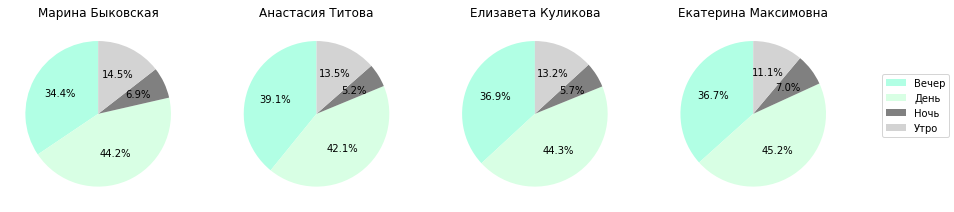

,name,timeofday,count_message,sum_count_symbol,sum_count_word
0,Анастасия Титова,Вечер,19193,450282,81526
1,Анастасия Титова,День,20642,467627,85651
2,Анастасия Титова,Ночь,2559,62459,11069
3,Анастасия Титова,Утро,6638,152943,27991
4,Екатерина Максимовна,Вечер,21870,345269,63870
5,Екатерина Максимовна,День,26949,429208,79690
6,Екатерина Максимовна,Ночь,4192,68234,12442
7,Екатерина Максимовна,Утро,6638,102269,19204
8,Елизавета Куликова,Вечер,16473,415746,76872
9,Елизавета Куликова,День,19768,485060,89796


In [35]:
#Теперь для каждого участинка беседы определим количество сообщений по времени суток
df_timeofday = (df.groupby(['name', 'timeofday'])).agg(
    count_message = ('name', 'count')
    ,sum_count_symbol = ('countsymbols', 'sum')
    ,sum_count_word = ('countwords', 'sum')
).reset_index()

fig, ax = plt.subplots(1, 4, figsize=(15, 6))
colors = ['#b1ffe4', '#d8ffe4', 'grey','lightgrey']
names = list(set(names))
for i in range(len(names)):
        ax[i].pie(
            df_timeofday[df_timeofday['name'] == names[i]]['count_message']
            #,labels = df_timeofday[df_timeofday['name'] == names[i]]['timeofday']
            ,radius = 1
            ,colors = colors
            ,autopct='%1.1f%%'
            ,startangle=90
        )
        ax[i].set_title(names[i])
labels = df_timeofday[df_timeofday['name'] == 'Анастасия Титова']['timeofday']
fig.legend(labels = df_timeofday[df_timeofday['name'] == names[i]]['timeofday'], loc='right')
plt.show()

df_timeofday

In [20]:
#Получим года, для которых у нас есть информация по сообщениям
min_year = min(df['datetime'].dt.year)
max_year = max(df['datetime'].dt.year)
print(min_year)
print(max_year)

2020
2024


In [22]:
#Получаем информацию о количестве сообщений, слов и символов за год для каждого пользователя (с возможностью выбра года)
df1 = (df[
    df['datetime'].dt.year == int(input(f"Введите год от {min_year} до {max_year}: "))
         ].groupby(['name'])).agg(
    count_message = ('name', 'count')
    ,sum_count_symbol = ('countsymbols', 'sum')
    ,sum_count_word = ('countwords', 'sum')
).reset_index()
df1

Введите год от 2020 до 2024: 2021


,name,count_message,sum_count_symbol,sum_count_word
0,Анастасия Титова,22566,507240,92920
1,Екатерина Максимовна,26177,417480,76958
2,Елизавета Куликова,18305,430975,79679
3,Марина Быковская,5477,200619,34147


Мы рассматриваем статистику сообщений в беседе, состоящей из четырех человек: Анастасии, Екатерины, Марины и Елизаветы. 
Первое сообщение в беседе было написано 13 мая 2020 года. Все кроме Екатерины состояли в беседе с момента первого сообщения, Екатерина вступила позже, через 5 месяцев.

Количество сообщений, написанных Екатериной, превышает количество сообщений других участников. Количество сообщений, написанных Мариной, меньше, чем у других  участников. При этом, при таком же качественном соотношении в количестве слов и символов, доля слов и символов на одно сообщение у Марины выше, чем у остальных участников, а у Екатерины - ниже. 
Таким образом, можно сделать вывод, что у Екатерины было больше всего сообщений, не содержащих текста (например, отправленных стикеров). Этот вывод подтверждается информацией о количестве сообщений без текста: у Екатерины количество сообщений более чем в два раза больше, чем у каждого из других участников. 
Интересно, что даже в 2020 году Екатерина отправила больше всего сообщений, хотя состояла в беседе меньшее время.

Качественное соотношение количества сообщений, слов и символов по временам суток одинаковое для всех участников. Больше всего сообщений каждым участником написано днем, меньше всего - ночью. Больше всего и ночных, и дневных, и вечерних сообщений написала Екатерина, а вот утренних сообщений у Екатерины и Анастасии было одинаковое количество.

In [23]:
#Теперь получим информацию об общем количестве сообщений за каждый год
df1 = (df.groupby(df['datetime'].dt.year)).agg(count_message = ('name', 'count')).reset_index()
df1

,datetime,count_message
0,2020,21306
1,2021,72525
2,2022,48237
3,2023,21428
4,2024,4254


In [24]:
#Теперь перейдем к рассмотрению общего числа сообщений по месяцам каждого года. 
df2 = df.groupby(pd.Grouper(key='datetime', freq='M')).agg(count_message = ('name', 'count')).reset_index()

df2020 = df2[df2['datetime'].dt.year == 2020].copy()
df2021 = df2[df2['datetime'].dt.year == 2021].copy()
df2022 = df2[df2['datetime'].dt.year == 2022].copy()
df2023 = df2[df2['datetime'].dt.year == 2023].copy()
df2024 = df2[df2['datetime'].dt.year == 2024].copy()

df2 = (df2.groupby(df2['datetime'].dt.month)).agg(count_message = ('count_message', 'sum')).reset_index()

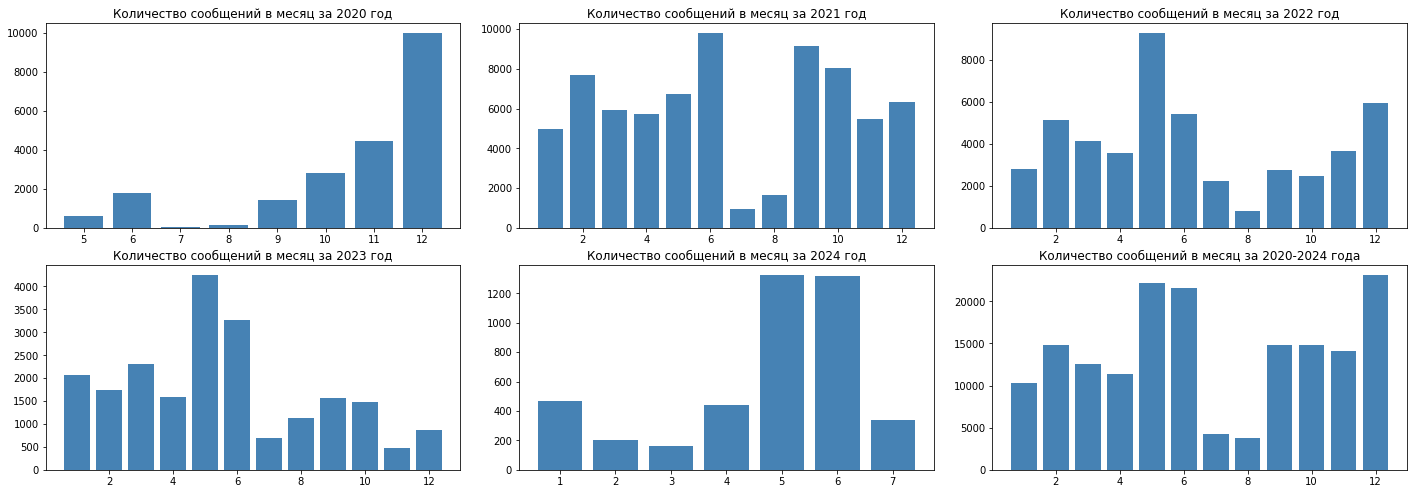

In [25]:
#Для наглядности отобразим зависимость количества сообщений в каждый месяц года на графиках.
#На оси x обозначен номер месяца, на оси y обозначено количество сообщений.
fig, axs = plt.subplots(2, 3, figsize=(20, 7))
axs[0][0].bar(df2020['datetime'].dt.month, df2020['count_message'], color='steelblue')
axs[0][1].bar(df2021['datetime'].dt.month, df2021['count_message'], color='steelblue')
axs[0][2].bar(df2022['datetime'].dt.month, df2022['count_message'], color='steelblue')
axs[1][0].bar(df2023['datetime'].dt.month, df2023['count_message'], color='steelblue')
axs[1][1].bar(df2024['datetime'].dt.month, df2024['count_message'], color='steelblue')
axs[1][2].bar(df2['datetime'], df2['count_message'], color='steelblue')

plt.tight_layout(pad=2.0)
axs[0][0].set_title(f'Количество сообщений в месяц за 2020 год')
axs[0][1].set_title(f'Количество сообщений в месяц за 2021 год')
axs[0][2].set_title(f'Количество сообщений в месяц за 2022 год')
axs[1][0].set_title(f'Количество сообщений в месяц за 2023 год')
axs[1][1].set_title(f'Количество сообщений в месяц за 2024 год')
axs[1][2].set_title(f'Количество сообщений в месяц за 2020-2024 года')

plt.show()

Суммарно наибольшее количество сообщений было написано в 2021 году. Скорее всего это имеет связь с дистанционным образованием (в 2021 году было больше всего дистанционных занятий). А также это связано с большим количеством предметов, требующих обсуждения и выполнения заданий, одинаковых для всех студентов.

В графиках распределений количества сообщений по месяцам, можно было предположить, что количество сообщений в беседе должно было увеличиваться в мае-июне и декабре-январе и уменьшаться в июле и августе. Т.е. увеличиваться во время сессии и уменьшаться в месяцы без учебы. Эти предположения частично подтверждаются на графиках количества сообщений по каждому году отдельно: в мае или июне количество сообщений максимальное, а вот в июле и августе количество сообщений мало. На рспределении суммарного количества сообщений по месяцам за все года отчетливо видно, что за декабрь, май и июнь суммарное число сообщений значительно увеличивалось, что, вместе с малым суммарным количеством сообщений за июль и август, подтверждает предположение. То, что суммарное количество сообщений в январе не выделяется можно объяснить тем, что в январе 2020 года беседа не существовала.

С 2021 по 2024 год наблюдается значительный спад в количестве сообщений. В июне 2024 года участники беседы завершили учебу, что сказывается на количестве сообщений и, конечно, это отразиться на дальнейшей статистике сообщений в беседе.